In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("en.openfoodfacts.org.products.csv", sep='\t', low_memory=False)

In [3]:
df.columns.values

array(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags',
       'brands', 'brands_tags', 'categories', 'categories_tags',
       'categories_en', 'origins', 'origins_tags', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en',
       'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo',
       'cities', 'cities_tags', 'purchase_places', 'stores', 'countries',
       'countries_tags', 'countries_en', 'ingredients_text', 'allergens',
       'allergens_en', 'traces', 'traces_tags', 'traces_en',
       'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n',
       'additives', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil',
       'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that

Only keep english ingredient lists

In [4]:
df_sel = df.loc[df["countries_en"].isin(["United Kingdom","United States"]), ["countries_en","ingredients_text"]]
df_sel.head()

,countries_en,ingredients_text
42,United States,"Bananas, vegetable oil (coconut oil, corn oil ..."
43,United States,"Peanuts, wheat flour, sugar, rice flour, tapio..."
92,United States,"Organic hazelnuts, organic cashews, organic wa..."
93,United States,Organic polenta
94,United States,"Rolled oats, grape concentrate, expeller press..."


Let's try with walnuts

In [5]:
df_en_walnut = df_sel[df_sel["ingredients_text"].str.contains("Walnut")==True]
df_en_walnut.head()

,countries_en,ingredients_text
494,United Kingdom,"Demerara Sugar, Sultanas (14%), Raisins (9.4%)..."
495,United Kingdom,"Demerara Sugar, Sultanas (14%), Raisins (9.4%)..."
2771,United States,"Walnuts, bht (0.02%) added to preserve freshness."
2772,United States,Walnuts.
2773,United States,Walnuts.


Filter list of ingredients

In [6]:
df_en_walnut_clean = df_en_walnut.copy()

df_en_walnut_clean["ingredients_text"] = (
    df_en_walnut["ingredients_text"]
    .apply(lambda x : re.sub(r"\.$", "",x ))  # remove trailing .
    .apply(lambda x : re.sub(r", ", ",", x))  # remove space after comma
    .apply(lambda x : re.sub(r"_", "", x))  # remove _
    .apply(lambda x : re.sub(r"[\s]*\([\w\d\s.\%]+\)[\w\d\s]*", "", x))  # remove percentages, "(B3)" like specification and everything after
    .apply(lambda x : re.sub(r"\.", ",",x ))  # transform any other . in ,
    .apply(lambda x : re.sub(r"[\w\s]+\[", "", x))  # remove composed ingredients with []
    .apply(lambda x : re.sub(r"[\w\s]+\(", "", x))  # remove composed ingredients with ()
    .apply(lambda x : re.sub(r"[\)\]]+", "", x))  # remove ) and ] leftovers
)

df_en_walnut_clean.head()

,countries_en,ingredients_text
494,United Kingdom,"Demerara Sugar,Sultanas,Raisins,Wheat Flour,Ca..."
495,United Kingdom,"Demerara Sugar,Sultanas,Raisins,Wheat Flour,Ca..."
2771,United States,"Walnuts,bht"
2772,United States,Walnuts
2773,United States,Walnuts


Create the list of ingredients

In [7]:
df_en_walnut_list = df_en_walnut_clean.copy()
df_en_walnut_list["ingredients_text"] = df_en_walnut_list["ingredients_text"].apply(lambda x : [s.lower() for s in x.split(",")])
df_en_walnut_list.head()

,countries_en,ingredients_text
494,United Kingdom,"[demerara sugar, sultanas, raisins, wheat flou..."
495,United Kingdom,"[demerara sugar, sultanas, raisins, wheat flou..."
2771,United States,"[walnuts, bht]"
2772,United States,[walnuts]
2773,United States,[walnuts]


Explode the list of ingredients, in order to calculate the index of each ingredient in the ingredient list and the global frequency

In [8]:
df_en_walnut_expl = df_en_walnut_list.explode("ingredients_text")
df_en_walnut_expl.head()

,countries_en,ingredients_text
494,United Kingdom,demerara sugar
494,United Kingdom,sultanas
494,United Kingdom,raisins
494,United Kingdom,wheat flour
494,United Kingdom,calcium carbonate


Calculate index in ingredient list

In [9]:
df_en_walnut_ingr = df_en_walnut_expl.copy()
df_en_walnut_ingr["ingr_index"] = df_en_walnut_ingr.groupby(df_en_walnut_ingr.index).cumcount()
df_en_walnut_ingr.head()

,countries_en,ingredients_text,ingr_index
494,United Kingdom,demerara sugar,0
494,United Kingdom,sultanas,1
494,United Kingdom,raisins,2
494,United Kingdom,wheat flour,3
494,United Kingdom,calcium carbonate,4


Calculate global count

In [10]:
df_en_walnut_ingr["ingr_count"] = df_en_walnut_ingr.groupby("ingredients_text")["ingr_index"].transform("count")
df_en_walnut_ingr.reset_index(inplace=True, drop=True)
df_en_walnut_ingr.head()

,countries_en,ingredients_text,ingr_index,ingr_count
0,United Kingdom,demerara sugar,0,11
1,United Kingdom,sultanas,1,6
2,United Kingdom,raisins,2,12
3,United Kingdom,wheat flour,3,18
4,United Kingdom,calcium carbonate,4,16


Since we want to maximize (count * low index in list) of ingredients, create a "rank" by inverting the index

In [11]:
max_index = df_en_walnut_ingr["ingr_index"].max()
max_index

89

In [12]:
df_en_walnut_ingr["ingr_rank"] = max_index - df_en_walnut_ingr["ingr_index"]
df_en_walnut_ingr.head()

,countries_en,ingredients_text,ingr_index,ingr_count,ingr_rank
0,United Kingdom,demerara sugar,0,11,89
1,United Kingdom,sultanas,1,6,88
2,United Kingdom,raisins,2,12,87
3,United Kingdom,wheat flour,3,18,86
4,United Kingdom,calcium carbonate,4,16,85


Find mean rank for each ingredient

In [13]:
df_en_walnut_ingr["ingr_mean_rank"] = df_en_walnut_ingr.groupby("ingredients_text")["ingr_rank"].transform("mean")
df_en_walnut_ingr.head()

,countries_en,ingredients_text,ingr_index,ingr_count,ingr_rank,ingr_mean_rank
0,United Kingdom,demerara sugar,0,11,89,86.909091
1,United Kingdom,sultanas,1,6,88,88.333333
2,United Kingdom,raisins,2,12,87,83.750000
3,United Kingdom,wheat flour,3,18,86,73.611111
4,United Kingdom,calcium carbonate,4,16,85,75.812500


Finally, calculate the score of each ingredient (count * mean rank)

In [14]:
df_en_walnut_score = df_en_walnut_ingr[["ingredients_text","ingr_count","ingr_mean_rank"]].copy()
df_en_walnut_score.drop_duplicates(inplace=True)
df_en_walnut_score.head()

,ingredients_text,ingr_count,ingr_mean_rank
0,demerara sugar,11,86.909091
1,sultanas,6,88.333333
2,raisins,12,83.750000
3,wheat flour,18,73.611111
4,calcium carbonate,16,75.812500


In [15]:
df_en_walnut_score["ingr_score"] = df_en_walnut_score["ingr_count"] * df_en_walnut_score["ingr_mean_rank"]
df_en_walnut_score.sort_values("ingr_score", ascending=False, inplace=True)
df_en_walnut_score.head()

,ingredients_text,ingr_count,ingr_mean_rank,ingr_score
20,walnuts,230,87.691304,20169.0
32,sugar,38,77.210526,2934.0
8,salt,29,66.379310,1925.0
21,almonds,18,73.722222,1327.0
3,wheat flour,18,73.611111,1325.0


The following are the most common ingredients in food containing walnuts

In [16]:
df_en_walnut_score["ingredients_text"].head(10)

20                    walnuts
32                      sugar
8                        salt
21                    almonds
3                 wheat flour
4           calcium carbonate
139             sunflower oil
16     glucose-fructose syrup
5                        iron
109               citric acid
Name: ingredients_text, dtype: object

Let's plot the relative score of these ingredients

In [17]:
max_score = df_en_walnut_score["ingr_score"].max()
max_score

20169.0

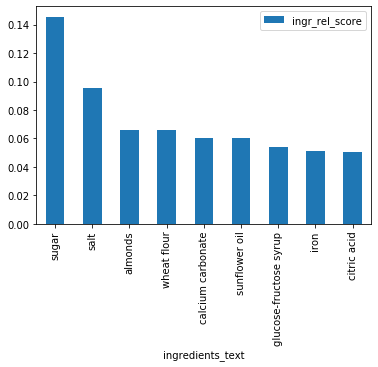

In [18]:
df_en_walnut_score["ingr_rel_score"] = df_en_walnut_score["ingr_score"] / max_score
df_en_walnut_score[1:10][["ingredients_text","ingr_rel_score"]].plot(kind="bar", x="ingredients_text")